In [33]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass
import pickle

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [34]:
%reload_ext autoreload
%autoreload 2

## Single-country model for predicting wealth index (Myanmar)
In this notebook, we normalized each model feature by country to correct country-specific feature quirks, as well as the wealth index.

This method has been done in a [similar study](https://doi.org/10.1073/pnas.2113658119) using DHS as training data and was also documented [here](https://www.dhsprogram.com/pubs/pdf/MR9/MR9.pdf).

Models recover how relative values of input data (relative to other locations in that country) correlate with relative values of wealth (also relative to other locations in that country).

The current best model setup involves (1) normalizing all features per country using `StandardScaler` and (2) scaling the wealth index per country using `StandardScaler`

## Set up Data Access

In [35]:
# Instantiate data managers for Ookla and OSM
# This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")

In [36]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

Username? jcnacpil@thinkingmachin.es
Password? ········


2023-02-21 11:31:48.093 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-02-21 11:31:48.094 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Load Target Country From DHS data

In [37]:
# Set country-specific variables
country_osm = "myanmar"
ookla_year = 2019
nightlights_year = 2015

In [38]:
dhs_household_dta_path = settings.DATA_DIR/"dhs/mm/MMHR71DT/MMHR71FL.DTA"
dhs_geographic_shp_path = settings.DATA_DIR/"dhs/mm/MMGE71FL/MMGE71FL.shp"
dhs_gdf = generate_dhs_cluster_level_data(
    dhs_household_dta_path, 
    dhs_geographic_shp_path, 
    col_rename_config="mm",
    convert_geoms_to_bbox=True,
    bbox_size_km=2.4
).reset_index(drop=True)
dhs_gdf.explore()

In [39]:
dhs_gdf.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-52232.000000,MM201500000001,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,8.0,Magway,GPS,R,20.058637,95.360081,107.0,105.0,WGS84,"POLYGON ((95.34859 20.06943, 95.37157 20.06943..."
1,2,130773.724138,MM201500000002,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,12.0,Yangon,GPS,U,17.112398,96.045616,31.0,14.0,WGS84,"POLYGON ((96.03432 17.12319, 96.05691 17.12319..."
2,3,-4955.000000,MM201500000003,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,10.0,Mon,GPS,R,16.507664,97.364236,4.0,2.0,WGS84,"POLYGON ((97.35298 16.51846, 97.37549 16.51846..."
3,4,47824.103448,MM201500000004,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,1.0,Kachin,GPS,U,26.684519,96.283879,193.0,210.0,WGS84,"POLYGON ((96.27180 26.69531, 96.29596 26.69531..."
4,5,9434.482759,MM201500000005,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,12.0,Yangon,GPS,R,16.866059,96.053499,12.0,5.0,WGS84,"POLYGON ((96.04222 16.87685, 96.06478 16.87685..."


## Generate Base Features

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the ff. datasets from the internet. 

- OpenStreetMap Data from Geofabrik
- Ookla Internet Speed Data
- VIIRS nighttime lights data from NASA EOG

On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [40]:
%%time
country_data = dhs_gdf.copy()

# Add in OSM features
country_data = osm.add_osm_poi_features(country_data, country_osm, osm_data_manager)
country_data = osm.add_osm_road_features(country_data, country_osm, osm_data_manager)

# Add in Ookla features
country_data = ookla.add_ookla_features(country_data, 'fixed', ookla_year, ookla_data_manager)
country_data = ookla.add_ookla_features(country_data, 'mobile', ookla_year, ookla_data_manager)

# Add in the nighttime lights features
country_data = nightlights.generate_nightlights_feature(country_data, str(nightlights_year)) 


2023-02-21 11:31:54.912 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-02-21-single-country-normalized-features/../../data/data_cache/osm/myanmar? True
2023-02-21 11:31:54.914 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for myanmar being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-02-21-single-country-normalized-features/../../data/data_cache/osm/myanmar/gis_osm_pois_free_1.shp
2023-02-21 11:31:57.506 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-02-21-single-country-normalized-features/../../data/data_cache/osm/myanmar? True
2023-02-21 11:31:57.507 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for myanmar being loaded from /home/jc_tm/project_repos/unicef-ai4d-

CPU times: user 24.5 s, sys: 396 ms, total: 24.9 s
Wall time: 24.9 s


### Inspect the combined target country data

In [41]:
country_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 441 entries, 0 to 440
Data columns (total 83 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           441 non-null    int64   
 1   Wealth Index                       441 non-null    float64 
 2   DHSID                              441 non-null    object  
 3   DHSCC                              441 non-null    object  
 4   DHSYEAR                            441 non-null    float64 
 5   CCFIPS                             441 non-null    object  
 6   ADM1FIPS                           441 non-null    object  
 7   ADM1FIPSNA                         441 non-null    object  
 8   ADM1SALBNA                         441 non-null    object  
 9   ADM1SALBCO                         441 non-null    object  
 10  ADM1DHS                            441 non-null    float64 
 11  ADM1NAME                           44

In [42]:
country_data.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,mobile_2019_mean_avg_d_kbps_mean,mobile_2019_mean_avg_u_kbps_mean,mobile_2019_mean_avg_lat_ms_mean,mobile_2019_mean_num_tests_mean,mobile_2019_mean_num_devices_mean,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,1,-52232.000000,MM201500000001,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,0.084249,0.116014,0.100290,0.008462,0.100869
1,2,130773.724138,MM201500000002,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,826.298933,505.281935,1.226730,0.166726,0.077713,0.413245,3.301661,1.938653,0.959708,1.911360
2,3,-4955.000000,MM201500000003,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,843.116769,375.838860,1.581117,0.281163,0.082694,0.075951,1.287470,0.431493,0.367520,0.277878
3,4,47824.103448,MM201500000004,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,NaN,NaN,NaN,NaN,NaN,0.087990,0.145543,0.117616,0.015429,0.115754
4,5,9434.482759,MM201500000005,MM,2015.0,BM,NULL,NULL,NULL,NULL,...,745.823942,688.509072,0.889722,0.244145,0.141459,1.886424,13.847748,9.098659,2.738587,9.385050


## Data Preparation

### Split into labels and features

In [43]:
# Set parameters
label_col = 'Wealth Index'
group_col = 'DHSCC'

In [44]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = country_data[[label_col]]

# For features, drop all columns from the input country geometries
# If you need the cluster data, refer to country_data / country_test
input_dhs_cols = dhs_gdf.columns
features = country_data.drop(input_dhs_cols, axis=1)

features.shape, labels.shape

((441, 61), (441, 1))

### Normalize labels and features

In [45]:
def scale_col(X,scaler):
    X_ = np.atleast_2d(X)
    return pd.DataFrame(scaler.fit_transform(X_), X.index)

In [46]:
feature_cols = features.columns.tolist()
print(feature_cols)

['poi_count', 'atm_count', 'atm_nearest', 'bank_count', 'bank_nearest', 'bus_station_count', 'bus_station_nearest', 'cafe_count', 'cafe_nearest', 'charging_station_count', 'charging_station_nearest', 'courthouse_count', 'courthouse_nearest', 'dentist_count', 'dentist_nearest', 'fast_food_count', 'fast_food_nearest', 'fire_station_count', 'fire_station_nearest', 'food_court_count', 'food_court_nearest', 'fuel_count', 'fuel_nearest', 'hospital_count', 'hospital_nearest', 'library_count', 'library_nearest', 'marketplace_count', 'marketplace_nearest', 'pharmacy_count', 'pharmacy_nearest', 'police_count', 'police_nearest', 'post_box_count', 'post_box_nearest', 'post_office_count', 'post_office_nearest', 'restaurant_count', 'restaurant_nearest', 'social_facility_count', 'social_facility_nearest', 'supermarket_count', 'supermarket_nearest', 'townhall_count', 'townhall_nearest', 'road_count', 'fixed_2019_mean_avg_d_kbps_mean', 'fixed_2019_mean_avg_u_kbps_mean', 'fixed_2019_mean_avg_lat_ms_mean

In [47]:
#scale features
scaler = StandardScaler()
for col in feature_cols:
    print(col)
    features[col+'_scaled'] = scaler.fit_transform(features[[col]])
print(features.columns)

poi_count
atm_count
atm_nearest
bank_count
bank_nearest
bus_station_count
bus_station_nearest
cafe_count
cafe_nearest
charging_station_count
charging_station_nearest
courthouse_count
courthouse_nearest
dentist_count
dentist_nearest
fast_food_count
fast_food_nearest
fire_station_count
fire_station_nearest
food_court_count
food_court_nearest
fuel_count
fuel_nearest
hospital_count
hospital_nearest
library_count
library_nearest
marketplace_count
marketplace_nearest
pharmacy_count
pharmacy_nearest
police_count
police_nearest
post_box_count
post_box_nearest
post_office_count
post_office_nearest
restaurant_count
restaurant_nearest
social_facility_count
social_facility_nearest
supermarket_count
supermarket_nearest
townhall_count
townhall_nearest
road_count
fixed_2019_mean_avg_d_kbps_mean
fixed_2019_mean_avg_u_kbps_mean
fixed_2019_mean_avg_lat_ms_mean
fixed_2019_mean_num_tests_mean
fixed_2019_mean_num_devices_mean
mobile_2019_mean_avg_d_kbps_mean
mobile_2019_mean_avg_u_kbps_mean
mobile_2019_mea

In [48]:
# fill nas with 0
features = features.fillna(0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(array([ 24.,  64., 102., 100.,  47.,  43.,  28.,  23.,   7.,   3.]),
 array([-1.87092709, -1.35762472, -0.84432236, -0.33101999,  0.18228238,
         0.69558475,  1.20888711,  1.72218948,  2.23549185,  2.74879421,
         3.26209658]),
 <BarContainer object of 10 artists>)

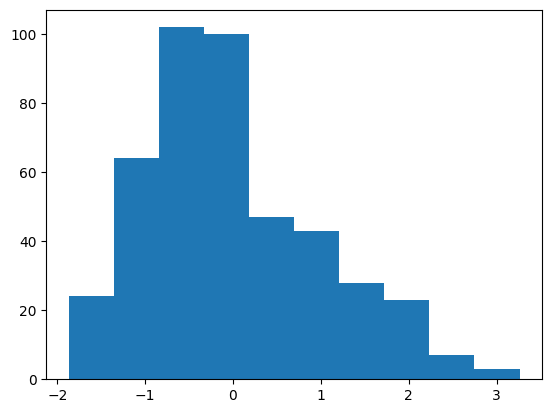

In [49]:
# # scale labels
scaler = StandardScaler()
labels[label_col] = scaler.fit_transform(labels)
plt.hist(labels)

In [50]:
# keep only scaled columns
features = features[[col+'_scaled' for col in feature_cols]]

### Base Features List

The features can be subdivided by the source dataset

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median


In [51]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 440
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          441 non-null    float64
 1   atm_count_scaled                          441 non-null    float64
 2   atm_nearest_scaled                        441 non-null    float64
 3   bank_count_scaled                         441 non-null    float64
 4   bank_nearest_scaled                       441 non-null    float64
 5   bus_station_count_scaled                  441 non-null    float64
 6   bus_station_nearest_scaled                441 non-null    float64
 7   cafe_count_scaled                         441 non-null    float64
 8   cafe_nearest_scaled                       441 non-null    float64
 9   charging_station_count_scaled             441 non-null    float64
 10  charging_station_nearest_scaled       

## Model Training

In [52]:
# Set parameters
cv_num_splits = 5
cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [53]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing {cv_num_splits}-fold CV...")
cv = RepeatedKFold(n_splits=cv_num_splits, n_repeats=cv_num_repeats, random_state=train_test_seed)

print(cv.split(features))


Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7f5ca89b2ba0>


### Instantiate model
For now, we will train a simple random forest model

In [54]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2
- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

In [55]:
R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
print("Cross validation scores are: ", R_cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.50443865 0.58872476 0.37784677 0.52861667 0.52811832 0.42550523
 0.49571929 0.52857584 0.60289731 0.27214761 0.50470748 0.63330664
 0.36916389 0.46477608 0.4533989  0.51349866 0.55547029 0.35468129
 0.4592297  0.63434267 0.49073443 0.4394482  0.39094755 0.52071749
 0.49542949]
Cross validation R^2 mean: 0.49
Cross validation R^2 std: 0.09


### Train the final model

For training the final model, we train on all the available data.

In [56]:
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

## Model Evaluation

### SHAP Feature Importance

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

In [58]:
shap_values

array([[-6.90438720e-02, -1.72419236e-03, -3.39928045e-02, ...,
        -5.66547440e-02, -4.95478380e-02, -1.35931532e-01],
       [ 2.34404202e-01, -4.94927878e-03, -3.27570447e-02, ...,
         8.07674312e-02,  1.92938126e-02,  1.88782841e-01],
       [ 1.94160403e-01, -1.96368342e-03, -3.65542527e-02, ...,
         5.13576327e-02, -2.45484107e-04,  3.68226735e-02],
       ...,
       [-6.52541149e-02, -4.03438283e-03, -3.51335985e-02, ...,
         1.50466457e-02,  2.58182875e-02,  6.16091946e-02],
       [-5.34823474e-02, -1.60837229e-03, -3.75018579e-02, ...,
         6.71334889e-02,  9.06166390e-03,  1.70344440e-01],
       [ 2.70321967e-01,  4.81148429e-02,  1.32760774e-01, ...,
         1.23834108e-01,  1.44330785e-02,  3.09171455e-01]])

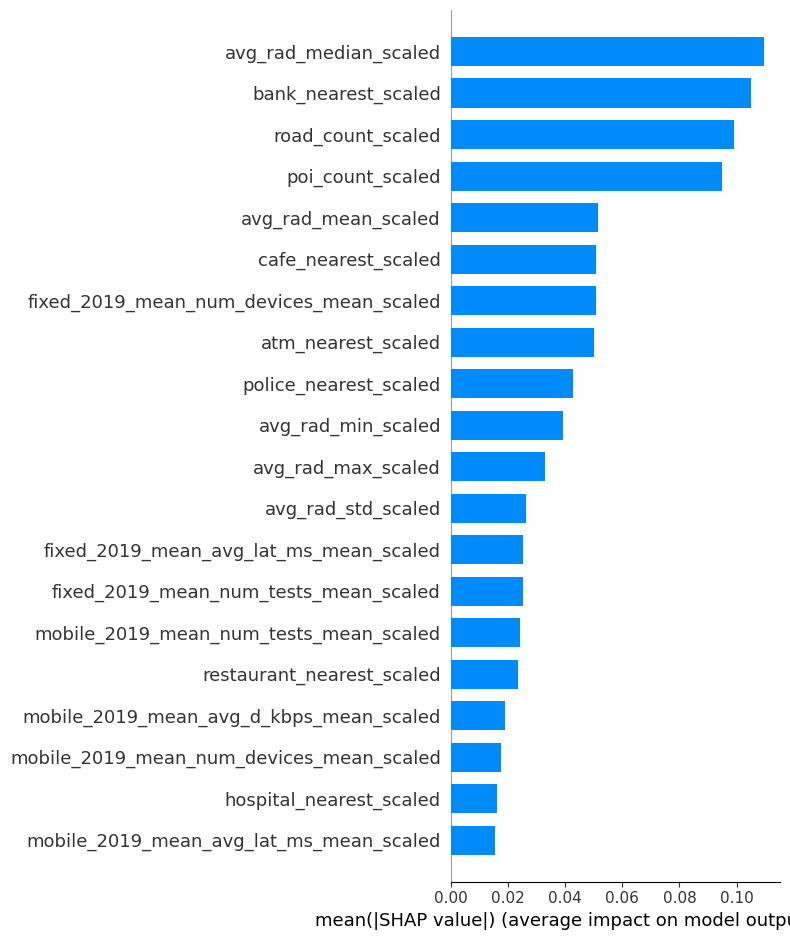

In [59]:
shap.summary_plot(shap_values, features, feature_names=features.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


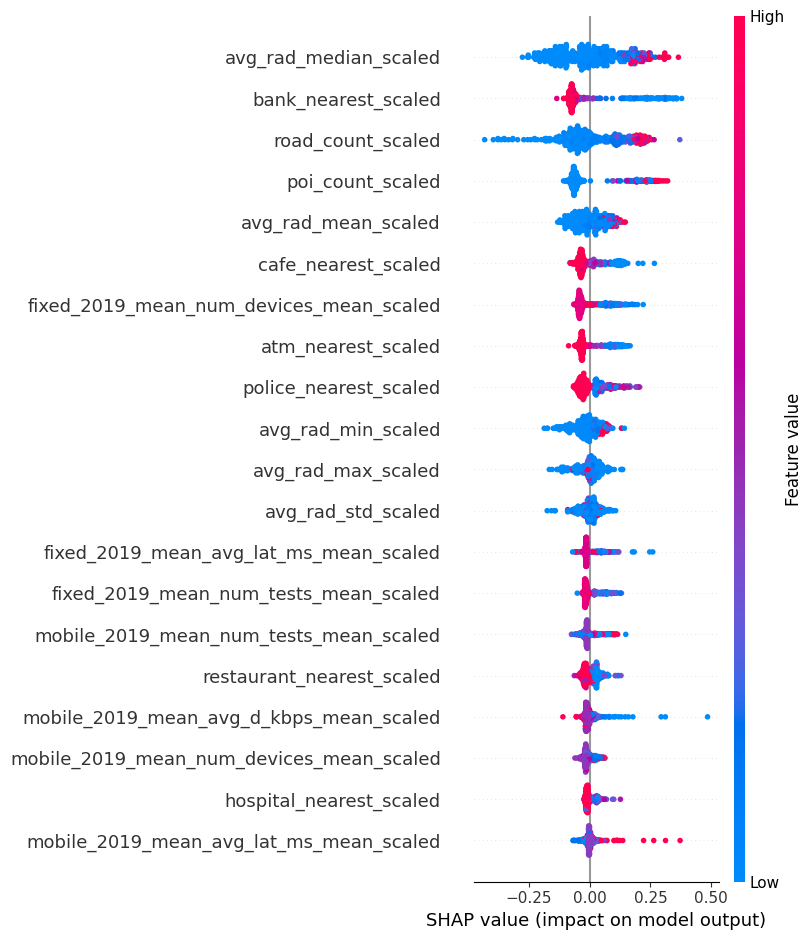

In [60]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [61]:
model_save_path = "./model_mm_normalized.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)